In [2]:
import pandas as pd
import numpy as np
import geopandas as gp
import shapely.geometry as sg
import datetime as dt
from matplotlib import cm
from matplotlib.lines import Line2D

#
# in macos pyenv with homebrew, make sure to install xz and readline for above libs to load properly
#
print("hey, all libs loaded")

def extract_activity(record):
    try:
        return record["activity"][0]["activity"][0]["type"]
    except:
        return "MISSING"

def parse_json(json):
    """
    parse lat/long coordinates into shapely.geometry.Point data structure 
    parse timestamps and try to extract activity, if available
    """
    points = [sg.Point(xy) for xy in zip(json.locations.apply(lambda x: x["longitudeE7"] / 10000000),
                                    json.locations.apply(lambda x: x["latitudeE7"] / 10000000))]
    df = gp.GeoDataFrame(geometry=points)
    locations = json.locations
    df["timestamp"] = locations.apply(lambda x: pd.to_datetime(x["timestampMs"], unit='ms'))
    df["accuracy"] = locations.apply(lambda x: x["accuracy"])
    df["velocity"] = locations.apply(lambda x: x.get("velocity", None))
    df["heading"] = locations.apply(lambda x: x.get("heading", None))
    df["altitude"] = locations.apply(lambda x: x.get("altitude", None))
    df["activity"] = locations.apply(extract_activity)
    return df
 
# yields a table (aka DataFrame) with many observations throughout the history
%time df = parse_json(pd.read_json("Location History.json"))

# when run for the first time, will raise lmz loading error, 
# this error goes away when run for a second time



hey, all libs loaded
CPU times: user 14.9 s, sys: 80.4 ms, total: 15 s
Wall time: 15.1 s


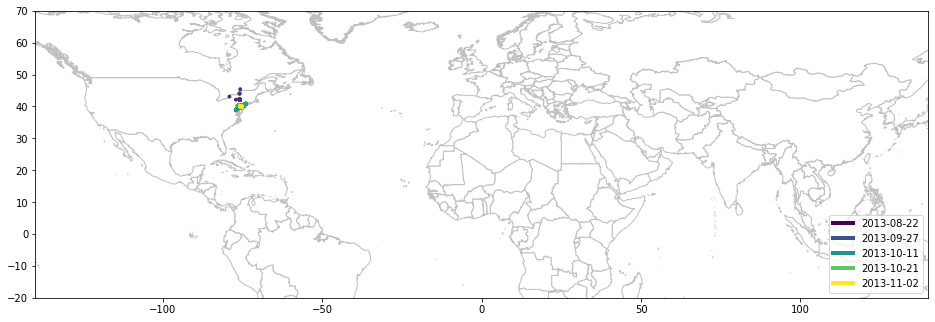

In [3]:
# http://thematicmapping.org/downloads/world_borders.php
world = gp.read_file('./TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp')

def seconds(timestamp):
    return timestamp.to_pydatetime().timestamp()
  
def calculate_pal(df2, cmap):
    min_ts = seconds(df2.timestamp.min())
    max_ts = seconds(df2.timestamp.max())
    return df2.timestamp.apply(lambda ts: cmap((seconds(ts) - min_ts) / (max_ts - min_ts))).tolist()
 
def compute_legend(df, ax, cmap, steps):
    vals = [x / (steps - 1) for x in range(steps)]
    custom_lines = [Line2D([0], [0], color=cmap(step), lw=4) for step in vals]
    labels = [df.timestamp.quantile(step).strftime("%Y-%m-%d") for step in vals]
    ax.legend(custom_lines, labels, loc="lower right")
    
def draw_map(df, box):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = world.plot(color='white', edgecolor='silver', figsize=(16,12))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    cmap = cm.get_cmap('viridis')
    pal = calculate_pal(box_only, cmap)
    ax = box_only.plot(ax=base, marker='o', color=pal, markersize=8)
    compute_legend(box_only, ax, cmap, 5)
    
draw_map(df, sg.box(-140, -20, 140, 70))

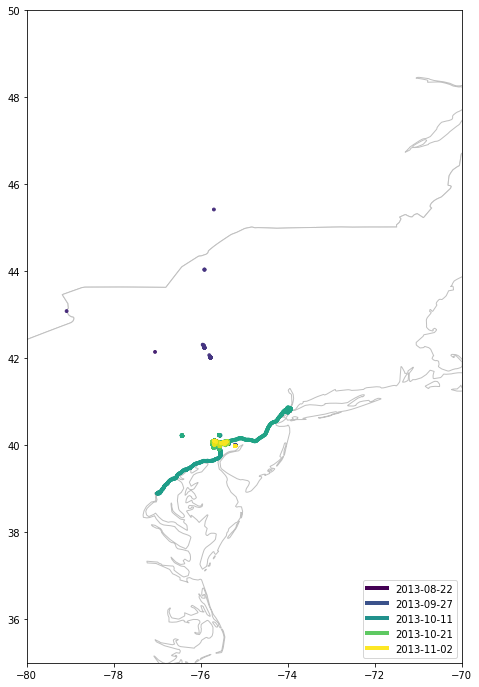

In [13]:
# create a zoomed-in plot
draw_map(df, sg.box(-80, 35, -70, 50))